In [1]:
!pip install numpy torch scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

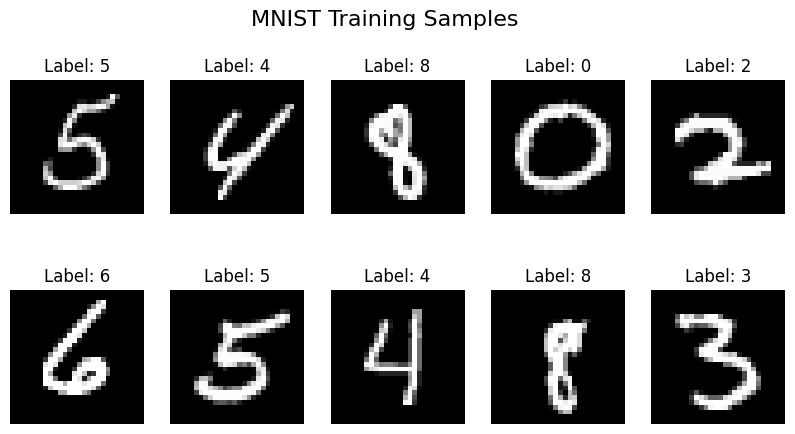

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

# Normalize to [0, 1]
X = MinMaxScaler().fit_transform(X)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot some digits
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("MNIST Training Samples", fontsize=16)
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class RBM(nn.Module):
    def __init__(self, n_visible=784, n_hidden=128):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.1)
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.v_bias = nn.Parameter(torch.zeros(n_visible))

    def sample_h(self, v):
        # Probability of hidden units given visible
        p_h = torch.sigmoid(torch.matmul(v, self.W.t()) + self.h_bias)
        return p_h, torch.bernoulli(p_h)

    def sample_v(self, h):
        # Probability of visible units given hidden
        p_v = torch.sigmoid(torch.matmul(h, self.W) + self.v_bias)
        return p_v, torch.bernoulli(p_v)

    def forward(self, v, k=1):
        # Contrastive Divergence (CD-k)
        v_k = v
        for _ in range(k):
            _, h_k = self.sample_h(v_k)
            _, v_k = self.sample_v(h_k)
        return v, v_k

Epoch 1/20, Loss: 0.4742


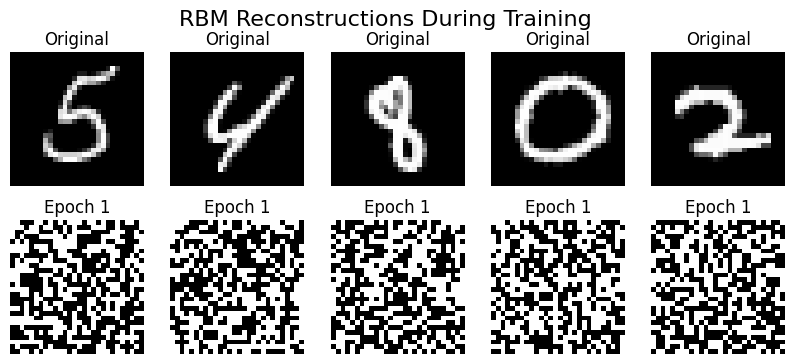

Epoch 2/20, Loss: 0.4742
Epoch 3/20, Loss: 0.4741
Epoch 4/20, Loss: 0.4742
Epoch 5/20, Loss: 0.4742
Epoch 6/20, Loss: 0.4740


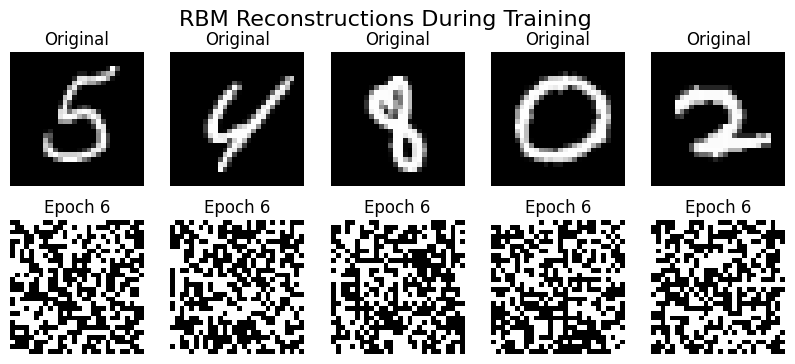

Epoch 7/20, Loss: 0.4741
Epoch 8/20, Loss: 0.4740
Epoch 9/20, Loss: 0.4743
Epoch 10/20, Loss: 0.4741
Epoch 11/20, Loss: 0.4741


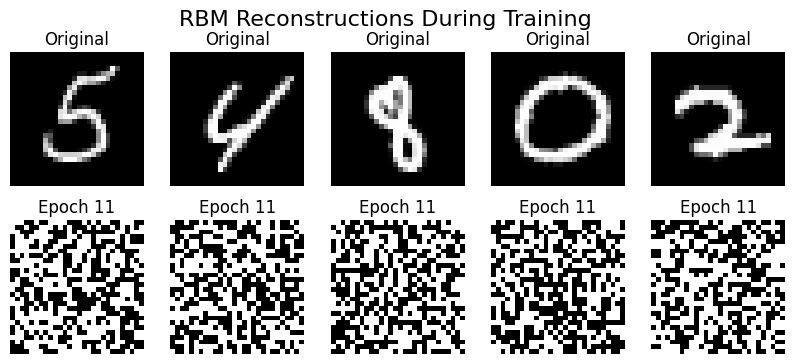

Epoch 12/20, Loss: 0.4744
Epoch 13/20, Loss: 0.4741
Epoch 14/20, Loss: 0.4741
Epoch 15/20, Loss: 0.4743
Epoch 16/20, Loss: 0.4742


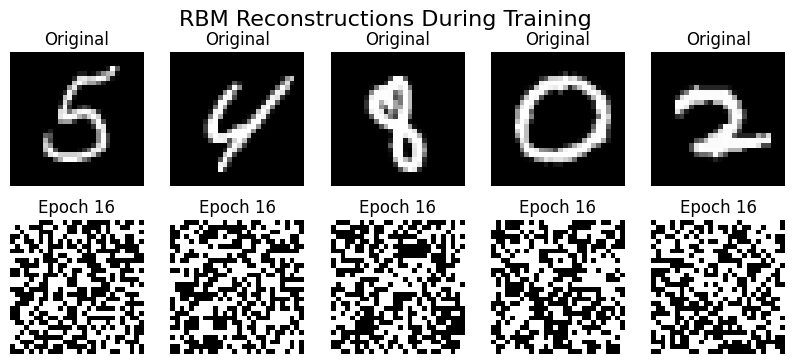

Epoch 17/20, Loss: 0.4742
Epoch 18/20, Loss: 0.4742
Epoch 19/20, Loss: 0.4743
Epoch 20/20, Loss: 0.4741


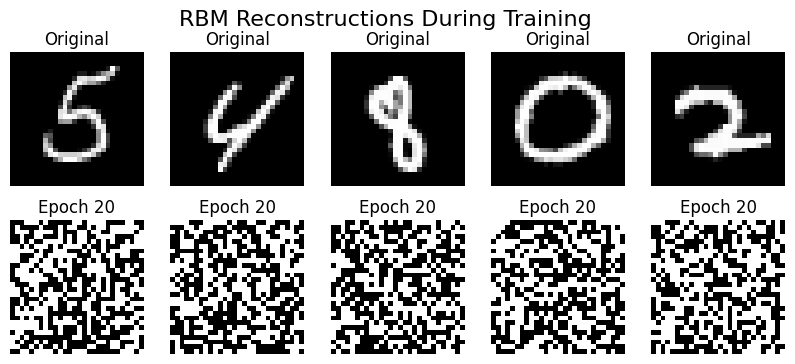

In [8]:
def train_rbm(X_train, n_hidden=128, epochs=20, batch_size=64, lr=0.01):
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

    # Initialize RBM
    rbm = RBM(X_train.shape[1], n_hidden)
    optimizer = optim.Adam(rbm.parameters(), lr=lr)

    # Store losses for plotting
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            v = batch[0]
            optimizer.zero_grad()

            # Forward pass (CD-1)
            v0, vk = rbm(v)

            # Reconstruction loss
            loss = torch.mean((v0 - vk) ** 2)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {losses[-1]:.4f}")

        # Plot reconstructions every 5 epochs
        if epoch % 5 == 0 or epoch == epochs - 1:
            with torch.no_grad():
                _, reconstructions = rbm(X_train_tensor[:5])  # Reconstruct first 5 samples
                plot_reconstructions(X_train[:5], reconstructions.numpy(), epoch)

    return rbm, losses

def plot_reconstructions(original, reconstructed, epoch):
    plt.figure(figsize=(10, 4))
    for i in range(5):
        # Original
        plt.subplot(2, 5, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed
        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title(f"Epoch {epoch + 1}")
        plt.axis('off')
    plt.suptitle("RBM Reconstructions During Training", fontsize=16)
    plt.show()

# Train RBM
rbm, losses = train_rbm(X_train, n_hidden=128, epochs=20)

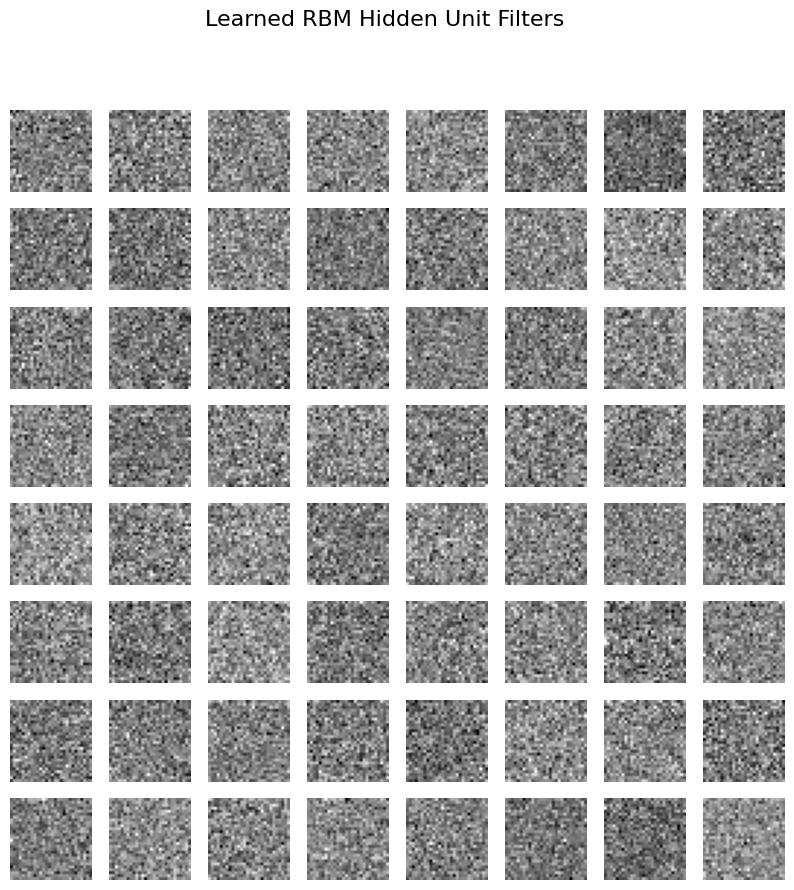

In [9]:
def plot_rbm_weights(rbm, n_rows=8, n_cols=8):
    weights = rbm.W.detach().numpy()
    plt.figure(figsize=(10, 10))
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(weights[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle("Learned RBM Hidden Unit Filters", fontsize=16)
    plt.show()

plot_rbm_weights(rbm)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Baseline: Train on raw pixels
clf_raw = LogisticRegression(max_iter=1000)
clf_raw.fit(X_train, y_train)
y_pred_raw = clf_raw.predict(X_test)
accuracy_raw = accuracy_score(y_test, y_pred_raw)
print(f"Raw Pixels Accuracy: {accuracy_raw * 100:.2f}%")

Raw Pixels Accuracy: 92.03%


In [11]:
# Extract features
def extract_features(rbm, data):
    data_tensor = torch.FloatTensor(data)
    p_h, _ = rbm.sample_h(data_tensor)
    return p_h.detach().numpy()

X_train_features = extract_features(rbm, X_train)
X_test_features = extract_features(rbm, X_test)

# Train on RBM features
clf_rbm = LogisticRegression(max_iter=1000)
clf_rbm.fit(X_train_features, y_train)
y_pred_rbm = clf_rbm.predict(X_test_features)
accuracy_rbm = accuracy_score(y_test, y_pred_rbm)
print(f"RBM Features Accuracy: {accuracy_rbm * 100:.2f}%")

RBM Features Accuracy: 90.19%


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Function to train an RBM on any dataset
def train_rbm(X_train, n_components=100, learning_rate=0.1, n_iter=10):
    rbm = BernoulliRBM(n_components=n_components, learning_rate=learning_rate, n_iter=n_iter, random_state=42)
    rbm.fit(X_train)
    return rbm

# Function to extract features using the trained RBM
def extract_features(rbm, X):
    return rbm.transform(X)

# Function to train and evaluate a classifier on RBM features
def train_classifier(X_train, y_train, X_test, y_test):
    clf = LogisticRegression(max_iter=5000, solver='lbfgs', multi_class='multinomial', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess: Flatten images and normalize
X_train = X_train.reshape(-1, 784) / 255.0
X_test = X_test.reshape(-1, 784) / 255.0

# Reduce dataset size for efficiency
X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=10000, stratify=y_train, random_state=42)
X_test, _, y_test, _ = train_test_split(X_test, y_test, train_size=2000, stratify=y_test, random_state=42)

# Train RBM
rbm = train_rbm(X_train)

# Extract features
X_train_rbm = extract_features(rbm, X_train)
X_test_rbm = extract_features(rbm, X_test)

# Train and evaluate classifier
accuracy = train_classifier(X_train_rbm, y_train, X_test_rbm, y_test)

print(f"Classification Accuracy using RBM Features: {accuracy * 100:.2f}%")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Accuracy using RBM Features: 92.00%


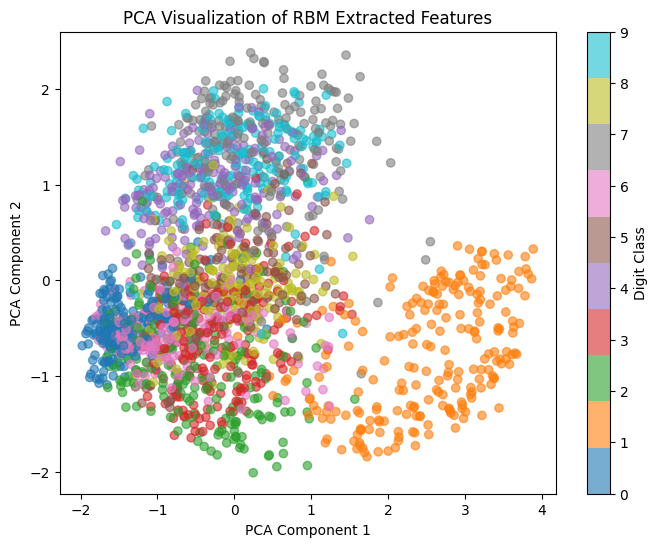

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to visualize RBM features using PCA
def plot_pca_features(X, y):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label="Digit Class")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("PCA Visualization of RBM Extracted Features")
    plt.show()

# Plot PCA visualization
plot_pca_features(X_test_rbm, y_test)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# RBM class implementation
class RBM(tf.keras.layers.Layer):
    def __init__(self, n_visible, n_hidden, lr=0.01, k=1):
        super(RBM, self).__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.lr = lr
        self.k = k  # Number of Gibbs sampling steps

        # Initialize weights and biases
        self.W = tf.Variable(
            tf.random.normal([n_visible, n_hidden], stddev=0.1),
            name="weights")
        self.v_bias = tf.Variable(
            tf.zeros([n_visible]), name="visible_bias")
        self.h_bias = tf.Variable(
            tf.zeros([n_hidden]), name="hidden_bias")

    def bernoulli(self, p):
        return tf.nn.relu(tf.sign(p - tf.random.uniform(tf.shape(p))))

    def sample_h(self, v):
        # Probability of hidden units given visible units
        h_prob = tf.sigmoid(tf.matmul(v, self.W) + self.h_bias)
        return self.bernoulli(h_prob), h_prob

    def sample_v(self, h):
        # Probability of visible units given hidden units
        v_prob = tf.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.v_bias)
        return self.bernoulli(v_prob), v_prob

    def contrastive_divergence(self, v0):
        # Gibbs sampling
        vk = v0
        for _ in range(self.k):
            hk, _ = self.sample_h(vk)
            vk, _ = self.sample_v(hk)

        # Positive and negative phases
        h0, ph0 = self.sample_h(v0)
        hk, phk = self.sample_h(vk)

        # Update weights and biases
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(vk), hk)

        delta_W = (positive_grad - negative_grad) / tf.cast(tf.shape(v0)[0], tf.float32)
        delta_v_bias = tf.reduce_mean(v0 - vk, axis=0)
        delta_h_bias = tf.reduce_mean(h0 - hk, axis=0)

        self.W.assign_add(self.lr * delta_W)
        self.v_bias.assign_add(self.lr * delta_v_bias)
        self.h_bias.assign_add(self.lr * delta_h_bias)

        # Reconstruction error
        error = tf.reduce_mean(tf.square(v0 - vk))
        return error

    def call(self, x):
        # Forward pass (used during fine-tuning)
        return tf.sigmoid(tf.matmul(x, self.W) + self.h_bias)

# Stacked RBM model
class StackedRBM:
    def __init__(self, layer_sizes):
        self.rbms = [RBM(layer_sizes[i], layer_sizes[i+1])
                    for i in range(len(layer_sizes)-1)]
        self.fine_tune_model = None

    def pretrain(self, x, epochs=10, batch_size=32):
        input_data = x
        for i, rbm in enumerate(self.rbms):
            print(f"Pretraining RBM layer {i+1} ({rbm.n_visible}->{rbm.n_hidden})")

            dataset = tf.data.Dataset.from_tensor_slices(input_data)
            dataset = dataset.shuffle(60000).batch(batch_size)

            for epoch in range(epochs):
                total_error = 0.0
                for batch in dataset:
                    error = rbm.contrastive_divergence(batch)
                    total_error += error

                avg_error = total_error / (len(input_data) / batch_size)
                print(f"Epoch {epoch+1}, Reconstruction Error: {avg_error:.4f}")

            # Transform data for next layer
            input_data = rbm.call(input_data).numpy()

    def build_fine_tune_model(self, n_classes):
        model = Sequential()

        # Add RBM layers
        for i, rbm in enumerate(self.rbms):
            if i == 0:
                model.add(Dense(rbm.n_hidden, activation='sigmoid',
                              input_shape=(rbm.n_visible,),
                              weights=[rbm.W.numpy(), rbm.h_bias.numpy()]))
            else:
                model.add(Dense(rbm.n_hidden, activation='sigmoid',
                              weights=[rbm.W.numpy(), rbm.h_bias.numpy()]))

        # Add output layer
        model.add(Dense(n_classes, activation='softmax'))

        model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

        self.fine_tune_model = model
        return model

# Example usage
if __name__ == "__main__":
    # Define the architecture
    layer_sizes = [784, 500, 200, 50]  # Input size and hidden layer sizes

    # Create and pretrain the stacked RBM
    s_rbm = StackedRBM(layer_sizes)
    s_rbm.pretrain(x_train, epochs=5, batch_size=32)

    # Build and fine-tune the model
    model = s_rbm.build_fine_tune_model(10)
    model.summary()

    # Fine-tune with labels
    history = model.fit(x_train, y_train,
                       epochs=10,
                       batch_size=32,
                       validation_data=(x_test, y_test))

    # Evaluate
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {test_acc:.4f}")